In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/MyDrive/Project_2_DPL

BiLSTM.py   disvoice	  kaldi_io		    mfcc.py	prosody.py   test.py
CAT.py	    HuBERT.py	  kaldi_io-0.9.8.dist-info  phonet	__pycache__  utils.py
dataset.py  hump_cat.pth  main_model.py		    predict.py	pysptk


In [3]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=f849afde61b26e1e6e5a01e75e89dddd1aecd17aa2e9470f48cc2388aff93199
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Project_2_DPL')

In [5]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from main_model import HuMP_CAT  # Import model
from dataset import EMOTION_MAP
from utils import collate_fn
from dataset import RAVDESSDataset
from torch.utils.data import DataLoader

# ✅ Load model


# ✅ Load dataset test
test_folder = r"/content/drive/MyDrive/RAVDESS_dataset/ravdess/test"
test_data = RAVDESSDataset(test_folder, device)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"✅ Dữ liệu test có {len(test_data)} samples.")

# 🔹 Khởi tạo danh sách lưu nhãn dự đoán và nhãn thực tế


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

/content/drive/MyDrive/Project_2_DPL/disvoice/prosody/prosody.py:309: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio = read(audio)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcoun

✅ Dữ liệu test có 288 samples.


In [108]:
all_preds = []
all_labels = []

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8  # Số lớp cảm xúc
model = HuMP_CAT(embed_dim=256, num_heads=4, embed_dim_x1=256, embed_dim_x2=256, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/Project_2_DPL/hump_cat.pth", weights_only=True))  # Load trọng số
model.eval()  # Chuyển về chế độ evaluation
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [110]:
from collections import Counter

counts = Counter(test_data.labels)
print(counts)  # Trả về một dictionary {giá trị unique: số lần xuất hiện}

Counter({'sad': 44, 'fearful': 43, 'surprised': 38, 'happy': 37, 'angry': 37, 'calm': 35, 'disgust': 35, 'neutral': 19})


In [111]:
correct, total = 0, 0

for i, (mfcc, prosody, hubert, labels) in enumerate(test_loader):
    mfcc, prosody, hubert, labels = mfcc.to(device), prosody.to(device), hubert.to(device), labels.to(device)

    with torch.no_grad():
        logits = model(hubert, mfcc, prosody, device)
        probs = F.softmax(logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        true_label = torch.argmax(labels, dim=1).item()

    all_preds.append(pred_label)
    all_labels.append(true_label)

    is_correct = pred_label == true_label
    correct += is_correct
    total += 1

    #print(f"🎯 Sample {i+1}: Dự đoán -> {list(EMOTION_MAP.values())[pred_label]} | Thực tế -> {list(EMOTION_MAP.values())[true_label]} {'✅ Đúng' if is_correct else '❌ Sai'}")

# 🔹 Tính độ chính xác


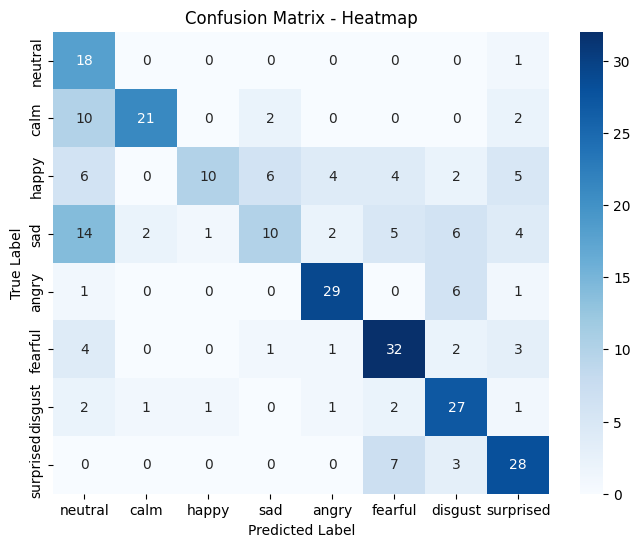

In [113]:
# 🔹 Dự đoán trên tập test

# 🔹 Tạo Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# 🔹 Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(EMOTION_MAP.values()), yticklabels=list(EMOTION_MAP.values()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Heatmap")
plt.show()


In [112]:
accuracy = correct / total * 100
print(f"\n📊 Độ chính xác trên tập test: {accuracy:.2f}%")


📊 Độ chính xác trên tập test: 60.76%
